In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import os.path
from pathlib import Path

import dotenv
import json
import pyam
import scmdata
import openscm_runner
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm.autonotebook as tqdman
import pyrcmip
import pyrcmip.assessed_ranges
import pyrcmip.metric_calculations
from pymagicc.io import MAGICCData

import utils

<IPython.core.display.Javascript object>

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/openscm_runner/progress.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [4]:
openscm_runner.adapters.MAGICC7.get_version()

'v7.5.3'

<IPython.core.display.Javascript object>

In [5]:
SRM_START_YEAR = 2030
MEMBERS = list(range(0, 599 + 1))  #
# MEMBERS = list(range(16)) + [165, 283]
YEARS = range(1750, 2500 + 1)

<IPython.core.display.Javascript object>

Settings to get climate sensitivity info

In [6]:
with open(os.environ["MAGICC_AR6_PROBABILISTIC_DISTRIBUTION"]) as f:
    prob_dist = json.load(f)

<IPython.core.display.Javascript object>

In [7]:
all_cfgs_df = pd.DataFrame(
    [
        {**c["nml_allcfgs"], "ensemble_member": c["paraset_id"]}
        for c in prob_dist["configurations"]
    ]
)
all_cfgs_df = all_cfgs_df.set_index("ensemble_member")
# all_cfgs_df["CORE_CLIMATESENSITIVITY"].hist()

<IPython.core.display.Javascript object>

## Calculate TCR, TCRE for ensemble members we've used

In [8]:
import pymagicc.io

keep_keys = [
    #     "bcoc_switchfromrf2emis_year",
    "ch4_incl_ch4ox",
    "ch4_switchfromconc2emis_year",
    "co2_fertilization_yrstart",
    "co2_preindco2conc",
    "co2_preindco2conc_apply",
    "co2_switchfromconc2emis_year",
    "co2_tempfeedback_yrstart",
    #     "core_amv_apply",
    #     "core_elnino_apply",
    #     "fgas_files_conc",
    #     "fgas_files_emis",
    #     "fgas_switchfromconc2emis_year",
    #     "file_bcb_emis",
    #     "file_bcb_ot",
    #     "file_bcb_rf",
    #     "file_bci_emis",
    #     "file_bci_ot",
    #     "file_bci_rf",
    #     "file_bcsnow_rf",
    #     "file_ch4b_emis",
    #     "file_ch4i_emis",
    "file_ch4_conc",
    #     "file_co2b_emis",
    #     "file_co2i_emis",
    "file_co2_conc",
    #     "file_cob_emis",
    #     "file_coi_emis",
    #     "file_emisscen",
    #     "file_emisscen_2",
    #     "file_emisscen_3",
    #     "file_emisscen_4",
    #     "file_emisscen_5",
    #     "file_emisscen_6",
    #     "file_emisscen_7",
    #     "file_emisscen_8",
    #     "file_landuse_rf",
    #     "file_mineraldust_rf",
    #     "file_n2ob_emis",
    #     "file_n2oi_emis",
    "file_n2o_conc",
    #     "file_nh3b_emis",
    #     "file_nh3i_emis",
    #     "file_nmvocb_emis",
    #     "file_nmvoci_emis",
    #     "file_noxb_emis",
    #     "file_noxi_emis",
    #     "file_ocb_emis",
    #     "file_ocb_ot",
    #     "file_ocb_rf",
    #     "file_oci_emis",
    #     "file_oci_ot",
    #     "file_oci_rf",
    #     "file_ocn_ot",
    #     "file_solar_rf",
    #     "file_soxb_emis",
    #     "file_soxi_emis",
    #     "file_soxi_ot",
    #     "file_soxnb_ot",
    #     "file_soxt_rf",
    #     "file_volcanic_rf",
    #     "mhalo_files_conc",
    #     "mhalo_files_emis",
    #     "mhalo_switchfromconc2emis_year",
    "n2o_switchfromconc2emis_year",
    #     "rf_aer_constantafteryr",
    "rf_ch4_constantafteryr",
    "rf_co2_constantafteryr",
    #     "rf_fgas_constantafteryr",
    "rf_initialization_method",
    #     "rf_landuse_constantafteryr",
    #     "rf_mhalo_constantafteryr",
    #     "rf_mineraldust_constantafteryr",
    #     "rf_n2o_constantafteryr",
    #     "rf_stratoz_constantafteryr",
    "rf_total_constantafteryr",
    "rf_total_runmodus",
    #     "rf_tropoz_constantafteryr",
    "scen_co2bhistadjust_0no1scale2shift",
    "scen_histadjust_0no1scale2shift",
]
ONEPCTCO2_CFG = dict(
    pymagicc.io.read_cfg_file(
        os.path.join(
            os.path.dirname(os.environ["MAGICC_EXECUTABLE_7"]),
            "..",
            "run",
            "rcmip",
            "MAGTUNE_1PCTCO2.CFG",
        )
    )["nml_allcfgs"]
)

ONEPCTCO2_CFG["file_emisscen"] = "SSP245_EMMS.SCEN7"
ONEPCTCO2_CFG["file_emisscen_2"] = ""
ONEPCTCO2_CFG["file_emisscen_3"] = ""
ONEPCTCO2_CFG["file_emisscen_4"] = ""
ONEPCTCO2_CFG["file_emisscen_5"] = ""
ONEPCTCO2_CFG["file_emisscen_6"] = ""
ONEPCTCO2_CFG["file_emisscen_7"] = ""
ONEPCTCO2_CFG["file_emisscen_8"] = ""
ONEPCTCO2_CFG.pop("rf_volcanic_scale")
ONEPCTCO2_CFG.pop("rf_solar_scale")

ONEPCTCO2_CFG = {k: v for k, v in ONEPCTCO2_CFG.items() if k in keep_keys}

ONEPCTCO2_CFG

{'ch4_incl_ch4ox': 0,
 'ch4_switchfromconc2emis_year': 10000,
 'co2_fertilization_yrstart': 1850,
 'co2_preindco2conc': 284.31699879964185,
 'co2_preindco2conc_apply': 1,
 'co2_switchfromconc2emis_year': 10000,
 'co2_tempfeedback_yrstart': 1850,
 'file_ch4_conc': 'rcmip/PICONTROL_CH4_CONC.IN',
 'file_co2_conc': 'rcmip/1PCTCO2_CO2_CONC.IN',
 'file_n2o_conc': 'rcmip/PICONTROL_N2O_CONC.IN',
 'n2o_switchfromconc2emis_year': 10000,
 'rf_ch4_constantafteryr': 10000,
 'rf_co2_constantafteryr': 10000,
 'rf_initialization_method': 'ZEROSTARTSHIFT',
 'rf_total_constantafteryr': 10000,
 'rf_total_runmodus': 'CO2',
 'scen_co2bhistadjust_0no1scale2shift': 0,
 'scen_histadjust_0no1scale2shift': 0}

<IPython.core.display.Javascript object>

In [9]:
import pymagicc
import pymagicc.config

pymagicc.config.config["EXECUTABLE_7"] = os.environ["MAGICC_EXECUTABLE_7"]


def do_1pctco2_run(magicc, cfg, startyear=1850, endyear=2110):
    res_1pct_raw = magicc.run(
        out_dynamic_vars=[
            "DAT_SURFACE_TEMP",
            "DAT_CO2_CONC",
            "DAT_CO2_ERF",
            "DAT_CO2I_INVERSE_EMMS",
            #             "DAT_CO2_ATMOS_POOL",
            #             "DAT_CO2_LAND_POOL",
            #             "DAT_CO2_AIR2OCEAN_FLUX",
            #             "DAT_CO2_AIR2LAND_FLUX",
            #             "DAT_CO2I_EMIS",
            #             "DAT_CO2B_EMIS",
            "DAT_TOTAL_INCLVOLCANIC_ERF",
        ],
        only=None,
        out_ascii_binary="BINARY",
        out_binary_format=2,
        startyear=startyear,
        endyear=endyear,
        **ONEPCTCO2_CFG,
        **cfg,
    )

    res_1pct = scmdata.ScmRun(res_1pct_raw.timeseries())
    res_1pct["variable"] = res_1pct["variable"].apply(
        lambda x: "Emissions|CO2" if x == "CO2I_INVERSE_EMMS" else x
    )
    res_1pct["scenario"] = "1pctCO2"
    res_1pct = res_1pct.drop_meta("todo")

    def _convert_var(inp):
        if inp == "Surface Temperature":
            return "Surface Air Temperature Change"

        return inp

    res_1pct["variable"] = res_1pct["variable"].apply(_convert_var)

    res_1pct.metadata = res_1pct_raw.metadata

    return res_1pct

<IPython.core.display.Javascript object>

In [10]:
res_1pctco2 = []
with pymagicc.MAGICC7() as magicc:
    for member in tqdman.tqdm(MEMBERS):
        cfg_to_run = [
            d for d in prob_dist["configurations"] if d["paraset_id"] == member
        ]
        assert len(cfg_to_run) == 1
        cfg_to_run = cfg_to_run[0]["nml_allcfgs"]
        tmp = do_1pctco2_run(magicc, cfg_to_run, startyear=1850, endyear=2110)
        tmp["ensemble_member"] = member
        res_1pctco2.append(tmp)

res_1pctco2 = scmdata.run_append(res_1pctco2)

cumulative_emms = res_1pctco2.filter(variable="Emissions|CO2*").integrate()
res_1pctco2 = res_1pctco2.append(cumulative_emms)

# res_1pctco2

  0%|          | 0/600 [00:00<?, ?it/s]

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/pymagicc/core.py:436: UserWarning: magicc logged a WARNING message. Check the 'stderr' key of the result's `metadata` attribute.
  warnings.warn(
/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/pymagicc/core.py:436: UserWarning: magicc logged a WARNING message. Check the 'stderr' key of the result's `metadata` attribute.
  warnings.warn(


<IPython.core.display.Javascript object>

In [11]:
assessed_ranges = pd.DataFrame(
    [
        {
            "RCMIP name": "Transient Climate Response",
            "RCMIP variable": "Surface Air Temperature Change",
            "RCMIP region": "World",
            "RCMIP scenario": "1pctCO2",
            "evaluation_period_start": np.nan,
            "evaluation_period_end": np.nan,
            "norm_period_start": np.nan,
            "norm_period_end": np.nan,
            "unit": "K",
            "RCMIP evaluation method": "custom",
        },
        {
            "RCMIP name": "Transient Climate Response to Emissions",
            "RCMIP variable": "Surface Air Temperature Change,Cumulative Emissions|CO2",
            "RCMIP region": "World",
            "RCMIP scenario": "1pctCO2",
            "evaluation_period_start": np.nan,
            "evaluation_period_end": np.nan,
            "norm_period_start": np.nan,
            "norm_period_end": np.nan,
            "unit": "K / TtC",
            "RCMIP evaluation method": "custom",
        },
    ]
)
assessed_ranges = pyrcmip.assessed_ranges.AssessedRanges(assessed_ranges)
# assessed_ranges.db

<IPython.core.display.Javascript object>

In [12]:
CUSTOM_CALCULATORS = (
    pyrcmip.metric_calculations.CalculatorTCR,
    pyrcmip.metric_calculations.CalculatorTCRE,
)

<IPython.core.display.Javascript object>

In [13]:
tcr = assessed_ranges.calculate_metric_from_results(
    "Transient Climate Response",
    res_1pctco2,
    custom_calculators=CUSTOM_CALCULATORS,
).set_index("ensemble_member")

tcre = assessed_ranges.calculate_metric_from_results(
    "Transient Climate Response to Emissions",
    res_1pctco2,
    custom_calculators=CUSTOM_CALCULATORS,
).set_index("ensemble_member")

metrics = pd.DataFrame({"TCR": tcr["value"], "TCRE": tcre["value"]})
# metrics

<IPython.core.display.Javascript object>

In [14]:
# res_1pctco2.filter(region="World", variable="Surface Air Temperature Change").lineplot(
#     hue="ensemble_member"
# )

<IPython.core.display.Javascript object>

In [15]:
# res_1pctco2.filter(region="World", variable="Effective Radiative Forcing").lineplot(
#     hue="ensemble_member"
# )

<IPython.core.display.Javascript object>

In [16]:
# res_1pctco2.filter(region="World", variable="Atmospheric Concentrations|CO2").lineplot(
#     hue="ensemble_member"
# )

<IPython.core.display.Javascript object>

### Load in data, append all members together, add ECS and export as csv

In [14]:
def load_append_export(var, var_long):
    # empty list
    files_list = [
        Path(
            utils.DATA_DIR
            / f"15_{var}_trajectories"
            / f"{idh}_{SRM_START_YEAR}_{var_long}.csv"
        )
        for idh in MEMBERS
    ]

    # concat data files
    concat_data = pd.concat(
        [pd.read_csv(file) for file in files_list]  # , ignore_index=True
    )

    # add climate sensitivity info
    concat_data = concat_data.set_index(
        ["ensemble_member", "RUNNAME", "variable", "unit"]
    )

    meta_to_add = all_cfgs_df[["CORE_CLIMATESENSITIVITY"]]
    meta_to_add = meta_to_add.rename({"CORE_CLIMATESENSITIVITY": "ECS"}, axis="columns")
    meta_to_add = meta_to_add.loc[MEMBERS].drop_duplicates()
    meta_to_add = meta_to_add.join(metrics)

    concat_data = concat_data.join(meta_to_add).reset_index()

    scm_data = scmdata.ScmRun(concat_data)

    # round to 3 decimals
    scm_data = scm_data.round(3)

    # export to csv
    scm_data.to_csv(
        str(
            Path(
                utils.DATA_DIR
                / "interim"
                / "merged_15_trajectories"
                / f"merged_{var}_{SRM_START_YEAR}.csv"
            )
        )
    )

    return scm_data


RF_ = load_append_export("ERF", "EXTRA_RF")
T_ = load_append_export("T", "SURFACE_TEMP")

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/run.py:2246: UserWarning: There are small values which may be truncated during rounding. Either increase the numberof decimals or convert the units of the timeseries so that the quantities are larger.
  warnings.warn(
/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/run.py:2246: UserWarning: There are small values which may be truncated during rounding. Either increase the numberof decimals or convert the units of the timeseries so that the quantities are larger.
  warnings.warn(


<IPython.core.display.Javascript object>

In [18]:
RF_.timeseries()

,,,,,,,,,,,,time,1750-01-01 00:00:00,1751-01-01 00:00:00,1752-01-01 00:00:00,1753-01-01 00:00:00,1754-01-01 00:00:00,1755-01-01 00:00:00,1756-01-01 00:00:00,1757-01-01 00:00:00,1758-01-01 00:00:00,1759-01-01 00:00:00,...,2491-01-01 00:00:00,2492-01-01 00:00:00,2493-01-01 00:00:00,2494-01-01 00:00:00,2495-01-01 00:00:00,2496-01-01 00:00:00,2497-01-01 00:00:00,2498-01-01 00:00:00,2499-01-01 00:00:00,2500-01-01 00:00:00
ECS,RUNNAME,TCR,TCRE,climate_model,ensemble_member,iteration,model,region,run_id,scenario,unit,variable,,,,,,,,,,,,,,,,,,,,,
3.465865,ssp245,2.076717,1.950013,MAGICCv7.5.3,0,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.100,0.109,0.105,0.089,0.034,0.014,0.057,0.087,0.101,...,1.829,1.829,1.829,1.829,1.829,1.827,1.826,1.824,1.823,1.822
7.493596,ssp245,3.282946,3.471558,MAGICCv7.5.3,1,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.158,0.162,0.160,0.146,0.052,0.008,0.090,0.137,0.155,...,0.967,0.968,0.968,0.968,0.969,0.968,0.967,0.966,0.965,0.964
3.959654,ssp245,2.157176,2.118768,MAGICCv7.5.3,2,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.163,0.177,0.172,0.149,0.054,0.016,0.093,0.140,0.163,...,1.670,1.670,1.669,1.669,1.669,1.668,1.667,1.667,1.666,1.665
2.799460,ssp245,1.736502,1.500595,MAGICCv7.5.3,3,14,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.120,0.130,0.127,0.112,0.040,0.013,0.072,0.106,0.123,...,2.323,2.323,2.323,2.322,2.322,2.320,2.319,2.317,2.315,2.313
3.631638,ssp245,2.053698,1.793987,MAGICCv7.5.3,4,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.104,0.121,0.113,0.086,0.038,0.021,0.058,0.088,0.104,...,1.644,1.643,1.643,1.643,1.643,1.641,1.639,1.637,1.635,1.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.721067,ssp245,1.940123,1.830664,MAGICCv7.5.3,595,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.094,0.103,0.100,0.086,0.034,0.014,0.057,0.085,0.098,...,2.445,2.445,2.445,2.445,2.445,2.444,2.444,2.443,2.442,2.441
5.004814,ssp245,2.949461,2.953664,MAGICCv7.5.3,596,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.085,0.099,0.095,0.076,0.029,0.018,0.049,0.072,0.088,...,1.368,1.368,1.367,1.367,1.367,1.366,1.365,1.363,1.362,1.361
4.010374,ssp245,2.018515,1.932170,MAGICCv7.5.3,597,15,unspecified,World,0,unspecified,W/m^2,Effective Radiative Forcing,0.0,0.135,0.152,0.145,0.117,0.046,0.018,0.073,0.111,0.132,...,1.466,1.466,1.466,1.466,1.466,1.464,1.463,1.462,1.460,1.459


<IPython.core.display.Javascript object>

# End of notebook
Use script below to import MAGICCdata instead of .csv and append

In [20]:
# # Load in first member and then append the others
# def load_append_export_MAGICCdata(var, var_long):
#     DATA_FILE = Path(
#         utils.DATA_DIR / f"15_{var}_trajectories" / f"0_{SRM_START_YEAR}_{var_long}.IN"
#     )
#     DATA = MAGICCData(
#         str(DATA_FILE),
#         columns={"run_id": 0, "scenario": f"1.5 {SRM_START_YEAR}"},
#     )

#     for ID in MEMBERS[1:]:
#         DATA_FILE = Path(
#             utils.DATA_DIR
#             / f"15_{var}_trajectories"
#             / f"{ID}_{SRM_START_YEAR}_{var_long}.IN"
#         )
#         DATA_append = MAGICCData(
#             str(DATA_FILE),
#             columns={"run_id": ID, "scenario": f"1.5 {SRM_START_YEAR}"},
#         )
#         DATA = DATA.append(DATA_append)

#     DATA.to_csv(
#         str(
#             Path(
#                 utils.DATA_DIR
#                 / "interim"
#                 / "merged_15_trajectories"
#                 / f"merged_{var}_{SRM_START_YEAR}.csv"
#             )
#         )
#     )
#     # take only 2000-2500
#     return DATA  # .filter(year=YEARS)


# RF_ = load_append_export_MAGICCdata("ERF", "EXTRA_RF")
# T_ = load_append_export_MAGICCdata("T", "SURFACE_TEMP")

<IPython.core.display.Javascript object>

### Plot to check

/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


Text(0.5, 1.0, 'SRM start 2030; 600 ensemble members')

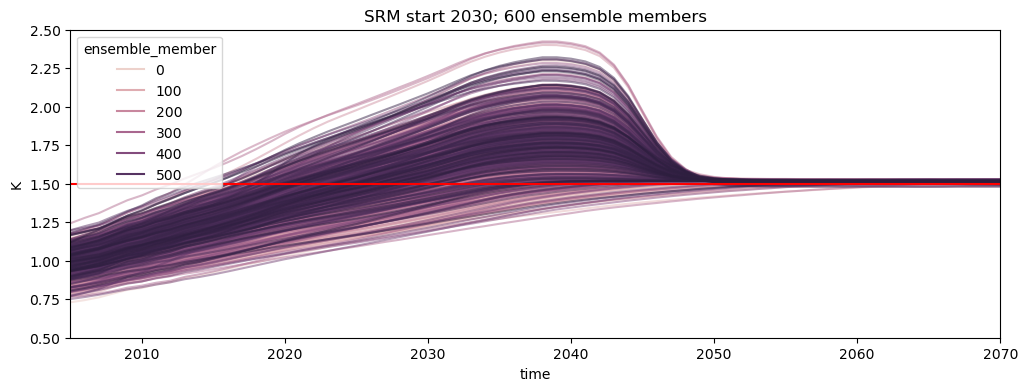

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
T_.lineplot(x="time", hue="ensemble_member", alpha=0.5, time_axis="year", ax=ax)
ax.set_ylim(0.5, 2.5)
ax.set_xlim([2005, 2070])
ax.axhline(
    1.5,
    color="r",
    linestyle="-",
)
# plt.hlines(
#     1.5,
#     np.datetime64("2005-01-01"),
#     np.datetime64("2060-01-01"),
#     color="r",
#     linestyle="-",
# )
# plt.title(
#     "SRM start " + str(SRM_START_YEAR) + "; ensemble members " + str(len(MEMBERS))
# )
ax.set_title(f"SRM start {SRM_START_YEAR}; {len(MEMBERS)} ensemble members")

/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


Text(0.5, 1.0, 'SRM start 2030; 600 ensemble members')

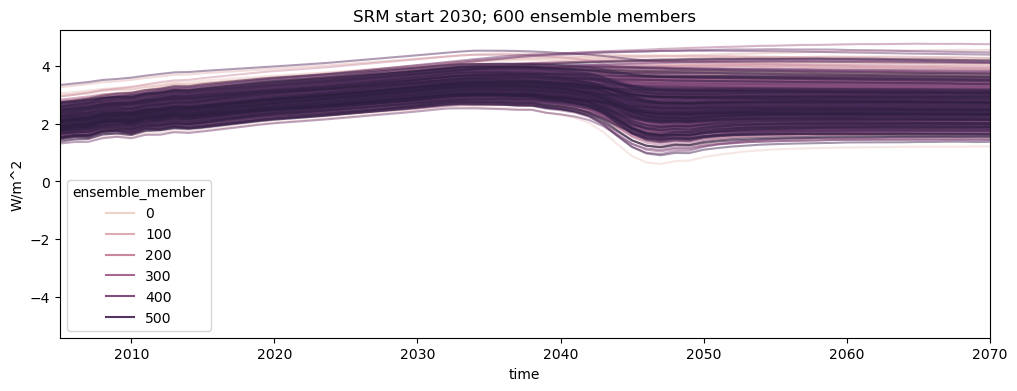

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
RF_.lineplot(x="time", hue="ensemble_member", alpha=0.5, time_axis="year", ax=ax)
# ax.set_ylim(0.5, 2.5)
ax.set_xlim([2005, 2070])
ax.set_title(f"SRM start {SRM_START_YEAR}; {len(MEMBERS)} ensemble members")

/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


(10957.0, 47482.0)

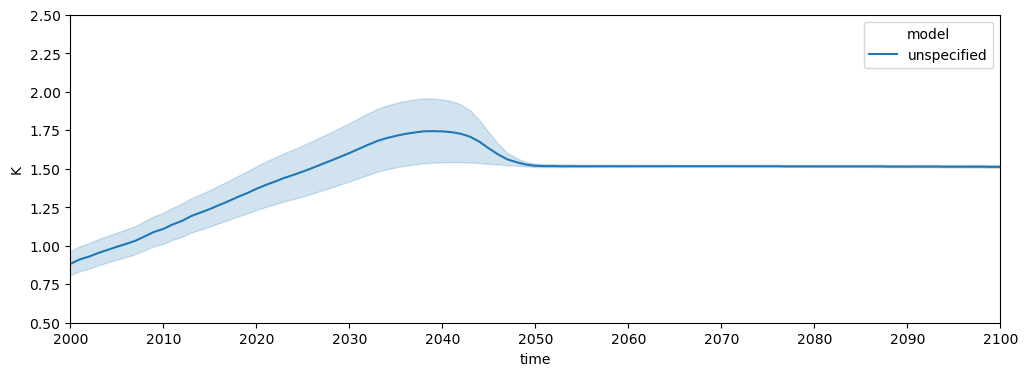

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
T_.lineplot(x="time", hue="model")
ax.set_ylim(0.5, 2.5)
ax.set_xlim(np.datetime64("2000-01-01"), np.datetime64("2100-01-01"))

/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


(3652.0, 47482.0)

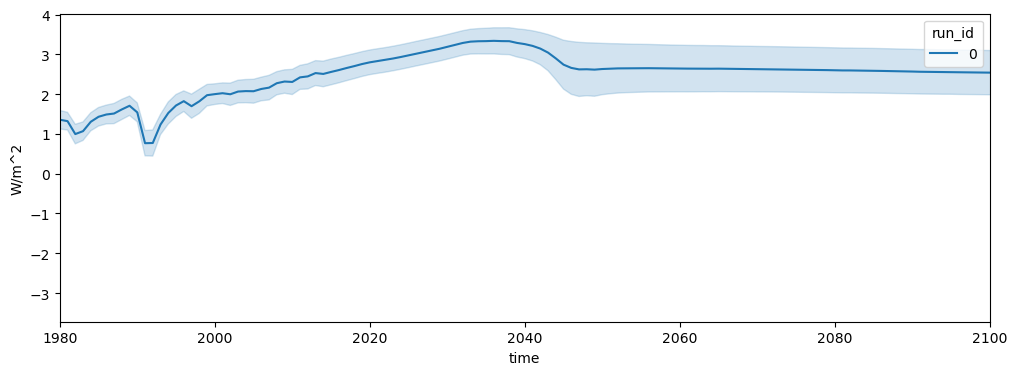

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
RF_.lineplot(x="time", hue="run_id")
# ax.set_ylim(0, 5)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2100-01-01"))